In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
df=pd.read_csv('friends_faces_160/target.txt', sep='\t', header=None)
df.columns=['image_path','character_number','character_name']

In [3]:
df.sample(10)

,image_path,character_number,character_name
2560,friends_faces_160\friends_335_900.png,7,Invalid
813,friends_faces_160\friends_1287_3418.png,7,Invalid
2995,friends_faces_160\friends_535_1326.png,7,Invalid
1515,friends_faces_160\friends_1550_4109.png,7,Invalid
793,friends_faces_160\friends_127_362.png,7,Invalid
399,friends_faces_160\friends_1133_3031.png,5,Joey
3422,friends_faces_160\friends_683_1728.png,1,Ross
612,friends_faces_160\friends_1215_3237.png,2,Chandler
737,friends_faces_160\friends_125_359.png,5,Joey
2214,friends_faces_160\friends_193_541.png,7,Invalid


In [4]:
df.groupby(["character_name","character_number"]).count().sort_values(by='character_number')

,,image_path
character_name,character_number,
Rachel,0,256
Ross,1,207
Chandler,2,184
Phoebe,3,202
Monica,4,213
Joey,5,199
Other,6,283
Invalid,7,2750


### Removing invalid and 'others' (= not Friends Gang)

In [5]:
df_filtered=df.loc[df.character_number<6]

In [6]:
df_filtered.head()

,image_path,character_number,character_name
0,friends_faces_160\Friends_new_0_1.png,5,Joey
14,friends_faces_160\friends_1002_2612.png,0,Rachel
20,friends_faces_160\friends_1004_2619.png,5,Joey
22,friends_faces_160\friends_1004_2621.png,4,Monica
30,friends_faces_160\friends_1006_2630.png,5,Joey


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
df_train2, df_test = train_test_split(df_filtered, stratify=df_filtered.character_number, train_size = 0.8,random_state=33)

In [9]:
df_test.head()

,image_path,character_number,character_name
3398,friends_faces_160\friends_673_1710.png,1,Ross
3055,friends_faces_160\friends_584_1377.png,4,Monica
2935,friends_faces_160\friends_48_144.png,5,Joey
262,friends_faces_160\friends_1076_2889.png,3,Phoebe
3472,friends_faces_160\friends_704_1774.png,3,Phoebe


In [10]:
df_test.shape

(253, 3)

In [11]:
df_test.character_name.value_counts()

Rachel      51
Monica      43
Ross        42
Phoebe      40
Joey        40
Chandler    37
Name: character_name, dtype: int64

In [12]:
df_train, df_val = train_test_split(df_train2, stratify=df_train2.character_number, train_size = 0.75,random_state=33)

In [13]:
df_val.head()

,image_path,character_number,character_name
1930,friends_faces_160\friends_1722_4514.png,1,Ross
387,friends_faces_160\friends_1129_3020.png,4,Monica
2509,friends_faces_160\friends_314_847.png,2,Chandler
3241,friends_faces_160\friends_636_1555.png,1,Ross
3183,friends_faces_160\friends_629_1495.png,3,Phoebe


In [14]:
df_val.shape

(252, 3)

In [15]:
df_val.character_name.value_counts()

Rachel      51
Monica      43
Ross        41
Phoebe      40
Joey        40
Chandler    37
Name: character_name, dtype: int64

In [17]:
df_train.shape

(756, 3)

In [18]:
df_train.character_name.value_counts()

Rachel      154
Monica      127
Ross        124
Phoebe      122
Joey        119
Chandler    110
Name: character_name, dtype: int64

### Loading images

In [19]:
X_train=[]
for path in df_train.image_path:
    image=cv2.imread(path)
    image=cv2.resize(image, (160,160))
    X_train.append(image)
X_train=np.array(X_train).astype(np.float32)

In [20]:
X_train.shape

(756, 160, 160, 3)

In [21]:
X_val=[]
for path in df_val.image_path:
    image=cv2.imread(path)
    image=cv2.resize(image, (160,160))
    X_val.append(image)
X_val=np.array(X_val).astype(np.float32)

In [22]:
X_val.shape

(252, 160, 160, 3)

In [23]:
X_test=[]
for path in df_test.image_path:
    image=cv2.imread(path)
    image=cv2.resize(image, (160,160))
    X_test.append(image)
X_test=np.array(X_test).astype(np.float32)

In [24]:
X_test.shape

(253, 160, 160, 3)

### Getting targets (= character's names)

In [25]:
y_train=np.array(df_train.character_number)

In [26]:
y_train.shape

(756,)

In [27]:
y_val=np.array(df_val.character_number)

In [28]:
y_val.shape

(252,)

In [29]:
y_test=np.array(df_test.character_number)

In [30]:
y_test.shape

(253,)

## Neural Network

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [32]:
batch_size = 16
dtype=torch.float32
device  = torch.device("cpu")
learning_rate = 1e-6

### Parameters

In [33]:
train_size=y_train.shape[0]

### Normalizing the data 

In [34]:
X_train_in=X_train/255
X_val_in=X_val/255
X_test_in=X_test/255

### Reshaping X for PyTorch processing

In [35]:
X_train_in = X_train_in.transpose(0,3,1,2)
X_val_in = X_val_in.transpose(0,3,1,2)
X_test_in = X_test_in.transpose(0,3,1,2)

In [36]:
np.max(X_train_in[0,1,...])

1.0

### Generating datasets and data loaders

In [37]:
train_dataset = TensorDataset(torch.from_numpy(X_train_in),torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val_in),torch.from_numpy(y_val))

In [38]:
val_batch_size = val_dataset.tensors[1].shape[0]
val_loader = DataLoader(val_dataset,batch_size=val_batch_size, shuffle=True)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)

### Defining train and validate functions

In [39]:
def train(model, device, train_loader, optimizer, epoch, train_size=train_size):
    model.train()
    mean_train_loss = 0
    correct = 0
    for data, target in train_loader:

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target, reduction='sum')
        loss.backward()
        mean_train_loss+=(loss.item()/ train_size)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        optimizer.step()
        
#     print(f'Train Epoch: {epoch} \tLoss: {mean_train_loss:.6f}\tCorrect: {correct}')
    return mean_train_loss, (correct/ train_size)

In [40]:
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    return val_loss, (correct/len(val_loader.dataset))

# Model 1 : 4 convolutional layers (filters = 32, 64, 256, 512)

In [41]:
epochs = 60
PYT_PATH = 'CNN_image1.pyt'

### Setting model and optimizer

In [44]:
from model_nn_bn_cv4 import Net
model1 = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer1 = optim.RMSprop(model1.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
loss_train_list=[]
loss_val_list=[]
correct_train_list=[]
correct_val_list=[]

correct_best = 0.

### Training the Neural Network

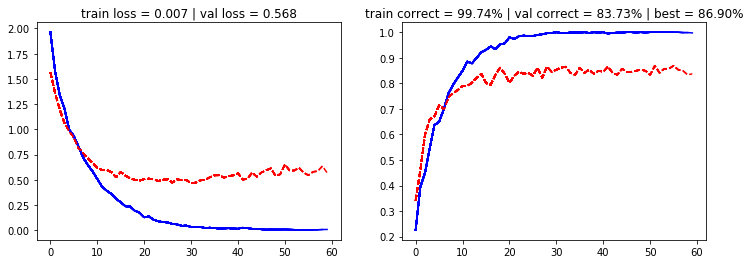

In [45]:
from IPython.display import display, clear_output

fig = plt.figure(figsize = (12,4))
ax1, ax2 = fig.subplots(1,2)


for epoch in range(1, epochs + 1):
    loss_train, correct_train=train(model1, device, train_loader, optimizer1, epoch)
    loss_val, correct_val=validate(model1, device, val_loader)
    
    loss_train_list.append(loss_train)
    loss_val_list.append(loss_val)
    correct_train_list.append(correct_train)
    correct_val_list.append(correct_val)
    
    if correct_best < correct_val:
        correct_best = correct_val
        torch.save(model1.state_dict(), PYT_PATH)

    ax1.plot(loss_train_list, 'b-')
    ax1.plot(loss_val_list,'r--')
    ax1.title.set_text(f'train loss = {loss_train:.3f} | val loss = {loss_val:.3f}')
    ax2.plot(correct_train_list, 'b-')
    ax2.plot(correct_val_list,'r--')
    ax2.title.set_text(f'train correct = {100.*correct_train_list[-1]:.2f}% | val correct = {100.*correct_val_list[-1]:.2f}% | best = {100.*correct_best:.2f}%')
    plt.savefig('evolution_'+PYT_PATH+'.svg')
    
    np.savez('evolution_'+PYT_PATH,
        loss_train_list=loss_train_list,
        loss_val_list=loss_val_list,
        correct_train_list=correct_train_list,
        correct_val_list=correct_val_list)
    
    display(fig)
    clear_output(wait=True)


In [ ]:
# 2 minutes / epoch

Futur possible improvement: include a condition (on the sliding average of correct_val?) to exit the loop of epochs 

## Evaluation of the model

### Load test data

In [46]:
X_test = torch.from_numpy(X_test_in).to(device)
Y_test = torch.from_numpy(y_test).to(device)

### Load already trained model

In [47]:
from model_nn_bn_cv4 import Net
model1_best = Net().to(device)
# load best state of the model
model1_best.load_state_dict(torch.load(PYT_PATH))

<All keys matched successfully>

### Use the network for inference

In [48]:
# set to eval for inference
model1_best.eval()
with torch.no_grad():
    output = model1_best(X_test)
    Y_hat1 = output.argmax(dim=1, keepdim=True).numpy().squeeze()

### Calculate the confusion matrix

In [49]:
from sklearn import metrics
import seaborn as sns

In [50]:
metrics.accuracy_score(Y_test,Y_hat1)

0.8537549407114624

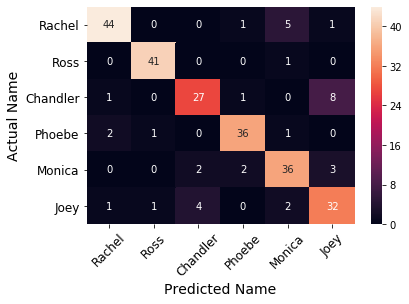

In [64]:
name_list=['Rachel', 'Ross', 'Chandler', 'Phoebe', 'Monica', 'Joey']
c_matrix = pd.DataFrame(metrics.confusion_matrix(Y_test,Y_hat1), columns=name_list, index=name_list)

ax=sns.heatmap(c_matrix, annot=True)
plt.xlabel('Predicted Name', fontsize=14)
plt.ylabel('Actual Name', fontsize=14)
ax.set_xticklabels(['Rachel', 'Ross', 'Chandler', 'Phoebe', 'Monica', 'Joey'],fontsize=12, rotation=45)
ax.set_yticklabels(['Rachel', 'Ross', 'Chandler', 'Phoebe', 'Monica', 'Joey'],fontsize=12)
plt.savefig('NN_confusion matrix_bn_cv4.svg', format='svg')
plt.show()

# Model2:  doubling the convolutional layers     
## (filters = 32,32,64,64,256,256,512,512)

In [52]:
epochs = 100
PYT_PATH = 'CNN_image2.pyt'

In [55]:
from model_nn_bn_cv4x2 import Net
model2 = Net().to(device)
optimizer2 = optim.RMSprop(model2.parameters(), lr=learning_rate, momentum=0.9)

loss_train_list=[]
loss_val_list=[]
correct_train_list=[]
correct_val_list=[]

correct_best = 0.

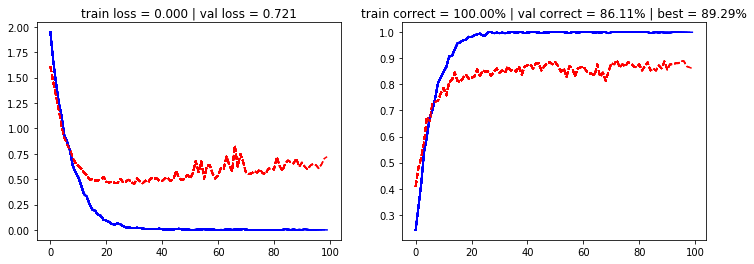

In [56]:
from IPython.display import display, clear_output

fig = plt.figure(figsize = (12,4))
ax1, ax2 = fig.subplots(1,2)


for epoch in range(1, epochs + 1):
    loss_train, correct_train=train(model2, device, train_loader, optimizer2, epoch)
    loss_val, correct_val=validate(model2, device, val_loader)
    
    loss_train_list.append(loss_train)
    loss_val_list.append(loss_val)
    correct_train_list.append(correct_train)
    correct_val_list.append(correct_val)
    
    if correct_best < correct_val:
        correct_best = correct_val
        torch.save(model2.state_dict(), PYT_PATH)

    ax1.plot(loss_train_list, 'b-')
    ax1.plot(loss_val_list,'r--')
    ax1.title.set_text(f'train loss = {loss_train:.3f} | val loss = {loss_val:.3f}')
    ax2.plot(correct_train_list, 'b-')
    ax2.plot(correct_val_list,'r--')
    ax2.title.set_text(f'train correct = {100.*correct_train_list[-1]:.2f}% | val correct = {100.*correct_val_list[-1]:.2f}% | best = {100.*correct_best:.2f}%')
    plt.savefig('evolution_'+PYT_PATH+'.svg')
    
    np.savez('evolution_'+PYT_PATH,
        loss_train_list=loss_train_list,
        loss_val_list=loss_val_list,
        correct_train_list=correct_train_list,
        correct_val_list=correct_val_list)
    
    display(fig)
    clear_output(wait=True)


In [ ]:
# 8 minutes / epoch

## Evaluation of the model

### Load already trained model

In [57]:
from model_nn_bn_cv4x2 import Net
model2_best = Net().to(device)
# load best state of the model
model2_best.load_state_dict(torch.load(PYT_PATH))

<All keys matched successfully>

### Use the network for inference

In [58]:
# set to eval for inference
model2_best.eval()
with torch.no_grad():
    output = model2_best(X_test)
    Y_hat2 = output.argmax(dim=1, keepdim=True).numpy().squeeze()

### Calculate the confusion matrix

In [59]:
metrics.accuracy_score(Y_test,Y_hat2)

0.8656126482213439

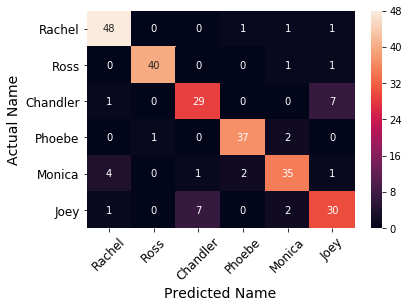

In [65]:

name_list=['Rachel', 'Ross', 'Chandler', 'Phoebe', 'Monica', 'Joey']
c_matrix = pd.DataFrame(metrics.confusion_matrix(Y_test,Y_hat2), columns=name_list, index=name_list)

ax=sns.heatmap(c_matrix, annot=True)
plt.xlabel('Predicted Name', fontsize=14)
plt.ylabel('Actual Name', fontsize=14)
ax.set_xticklabels(['Rachel', 'Ross', 'Chandler', 'Phoebe', 'Monica', 'Joey'],fontsize=12, rotation=45)
ax.set_yticklabels(['Rachel', 'Ross', 'Chandler', 'Phoebe', 'Monica', 'Joey'],fontsize=12)
plt.savefig('NN_confusion matrix_bn_cv4x2.svg', format='svg')
plt.show()